# How to Paint with Cycle Generative Adversarial Networks

   A Cycle GAN is a type of generative adversarial network (GAN) that is used to learn the mapping between two different domains. The goal of a Cycle GAN is to be able to translate images from one domain to another, such as converting a photograph of a horse into a painting of a horse. To create a Cycle GAN model, you would first need to gather a dataset of images from both domains. Then, you would define and train two separate generative models, one for each domain. These models would be trained to translate images from one domain to the other, and back again. Finally, you would combine the two models into a single Cycle GAN model, which can be used to translate images between the two domains.

![](https://godatadriven.com/wp-content/images/how-to-style-transfer/style-transfer-example.jpg)

## Why Cycle GAN

   Using a Cycle GAN can be a good idea for a number of reasons. First, a Cycle GAN can learn to translate images between two different domains without requiring any paired training data. This is useful because it can be difficult or impossible to collect such data for some tasks. Additionally, a Cycle GAN can learn to preserve the key characteristics of an image when translating it to a different domain, such as the overall shape and structure of the objects in the image. This can be useful for tasks such as image-to-image translation, where it is important to maintain the key features of an image. Finally, a Cycle GAN can be used for a variety of tasks, such as photo enhancement, style transfer, and domain adaptation.
   
### Delicious Cycle GAN
![](https://junyanz.github.io/CycleGAN/images/faces_and_ramens.jpg)

## Inspired by DCGAN, but Why?

DCGAN, or Deep Convolutional Generative Adversarial Network, is a type of GAN that uses deep convolutional neural networks to generate images. Some potential benefits of using a DCGAN include:

1. The ability to generate high-resolution images. DCGANs use deep convolutional networks, which are capable of processing large amounts of data and can generate high-resolution images.

2. The ability to generate diverse images. DCGANs can learn to generate a wide range of images, including images that are realistic and those that are more abstract.

3. The ability to control the features of generated images. By carefully controlling the training process, it is possible to use a DCGAN to generate images with specific characteristics, such as images that are centered around a particular object or images with a specific color scheme.

4. The ability to use unsupervised learning. Unlike many other generative models, a DCGAN can be trained using unsupervised learning, which means it can learn to generate images without the need for labeled training data.

Overall, DCGANs offer a powerful and flexible tool for generating images and can be used in a wide range of applications.


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
# import tensorflow_addons as tfa
import tensorflow_datasets as tfds

# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )

## TPU

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Number of replicas: 1
2.19.0


## Load the Data

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


2022-12-11 00:16:31.375410: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2022-12-11 00:16:31.462273: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [4]:
IMAGE_SIZE = [256, 256]

def normalize(image):
    return (tf.cast(image, tf.float32) / 127.5) - 1

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def random_crop(image):
    cropped_image = tf.image.random_crop(image, size=[256, 256, 3])
    return cropped_image

def random_jitter(image):
    image = tf.image.resize(image, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    return image

def flip(image):
    return tf.image.flip_left_right(image)

def preprocess_image_train(image, label=None):
    image = random_jitter(image)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(10000)
    return dataset

In [5]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=50).batch(100, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=2  ).batch(100, drop_remainder=True)

# DCGAN
## Network Upsample and Downsample

Here is the summary of DCGAN attribute we are testing:

- Replace all max pooling with convolutional stride
- Use transposed convolution for upsampling.
- Eliminate fully connected layers.
- Use Batch normalization except the output layer for the generator and the input layer of the discriminator.
- Use ReLU in the generator except for the output which uses tanh.
- Use LeakyReLU in the discriminator.

In [6]:
OUTPUT_CHANNELS = 3
LATENT_DIM = 1024

def downsample(filters, size, activation, dropout, apply_instancenorm=True, 
                                                   apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    #result.add(layers.MaxPool2D()) replaced

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(dropout))
    
    if activation == "leakyrelu":
        result.add(layers.LeakyReLU())
    elif activation == "relu":
        result.add(layers.ReLU())

    return result

In [7]:
def upsample(filters, size, activation, dropout, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(dropout))

    if activation == "leakyrelu":
        result.add(layers.LeakyReLU())
    elif activation == "relu":
        result.add(layers.ReLU())

    return result

## Build Network
In the Adam optimization algorithm, beta_1 and beta_2 are two hyperparameters that control the behavior of the algorithm. Beta_1 determines the decay rate for the first moment estimate, while beta_2 determines the decay rate for the second moment estimate. These parameters are used to compute an exponentially weighted average of the gradient and the squared gradient, which are used to update the weights in the network. In general, beta_1 and beta_2 are set to values close to 1, such as 0.9 and 0.999, respectively. This helps the Adam optimization algorithm to converge quickly and produce good results.

In [8]:
EPOCHS = 100

gen_lrate = 0.0002
dis_lrate = 0.0002

beta_1=0.9
beta_2=0.999

label_real = .9

## Encoder-decode

Bottleneck, upsampling, and downsampling are all techniques that are commonly used in deep learning models, including generative models such as GANs.

Bottleneck refers to a layer in a neural network that has a smaller number of units or channels than the layers surrounding it. This can help reduce the number of parameters in the model and prevent overfitting. In generative models, bottleneck layers can be used to compress the input data before it is processed by the rest of the network.

Upsampling and downsampling are techniques that are used to change the size or resolution of an image. Upsampling refers to increasing the size or resolution of an image, while downsampling refers to decreasing the size or resolution of an image. In generative models, upsampling and downsampling are often used in the generator network to manipulate the size of the input images and the size of the generated images.

Overall, these techniques can be useful for improving the performance and efficiency of deep learning models, including generative models such as GANs.

## Generator

![1.png](https://i.ibb.co/KV4pTWd/1.png)

In [9]:
def CycleGenerator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, "relu", 0.8, apply_instancenorm=False, apply_dropout=True),
        downsample(128, 4, "relu", 0.5, apply_dropout=True),
        downsample(256, 4, "relu", 0.5, apply_dropout=True),
        downsample(512, 4, "relu", 0.5),
        downsample(512, 4, "relu", 0.5),
        downsample(512, 4, "relu", 0.5),
        downsample(512, 4, "relu", 0.5),
        downsample(512, 4, "relu", 0.5),
    ]

    up_stack = [
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(256, 4, "relu", 0.5, apply_dropout=False),
        upsample(128, 4, "relu", 0.5, apply_dropout=False), 
        upsample(64, 4, "relu", 0.5, apply_dropout=False),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [10]:
def CycleGenerator_test():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, "leakyrelu", 0.8, apply_instancenorm=False, apply_dropout=False),
        downsample(128, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(256, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(512, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(512, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(512, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(512, 4, "leakyrelu", 0.5, apply_dropout=False),
        downsample(512, 4, "leakyrelu", 0.5, apply_dropout=False),
    ]

    up_stack = [
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=True),
        upsample(512, 4, "relu", 0.5, apply_dropout=False),
        upsample(256, 4, "relu", 0.5, apply_dropout=False),
        upsample(128, 4, "relu", 0.5, apply_dropout=False), 
        upsample(64, 4, "relu", 0.5, apply_dropout=False),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

## Discriminator

![2.png](https://i.ibb.co/gjG9dpP/2.png)

In [11]:
def CycleDiscriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, "leakyrelu", 0.8, apply_instancenorm = False, apply_dropout=True)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, "leakyrelu", 0.5)(down1)
    down3 = downsample(256, 4, "leakyrelu", 0.5)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last_conv = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [12]:
def CycleDiscriminator_test():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, "leakyrelu", 0.8, apply_instancenorm = False, apply_dropout=False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4, "leakyrelu", 0.5, apply_dropout=False)(down1)
    down3 = downsample(256, 4, "leakyrelu", 0.5, apply_dropout=False)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last_conv = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
with strategy.scope():
    monet_cycle_generator = CycleGenerator_test() # Photos to Monet 
    photo_cycle_generator = CycleGenerator_test() #  Monet to Photos

    monet_cycle_discriminator = CycleDiscriminator_test() 
    photo_cycle_discriminator = CycleDiscriminator_test() 

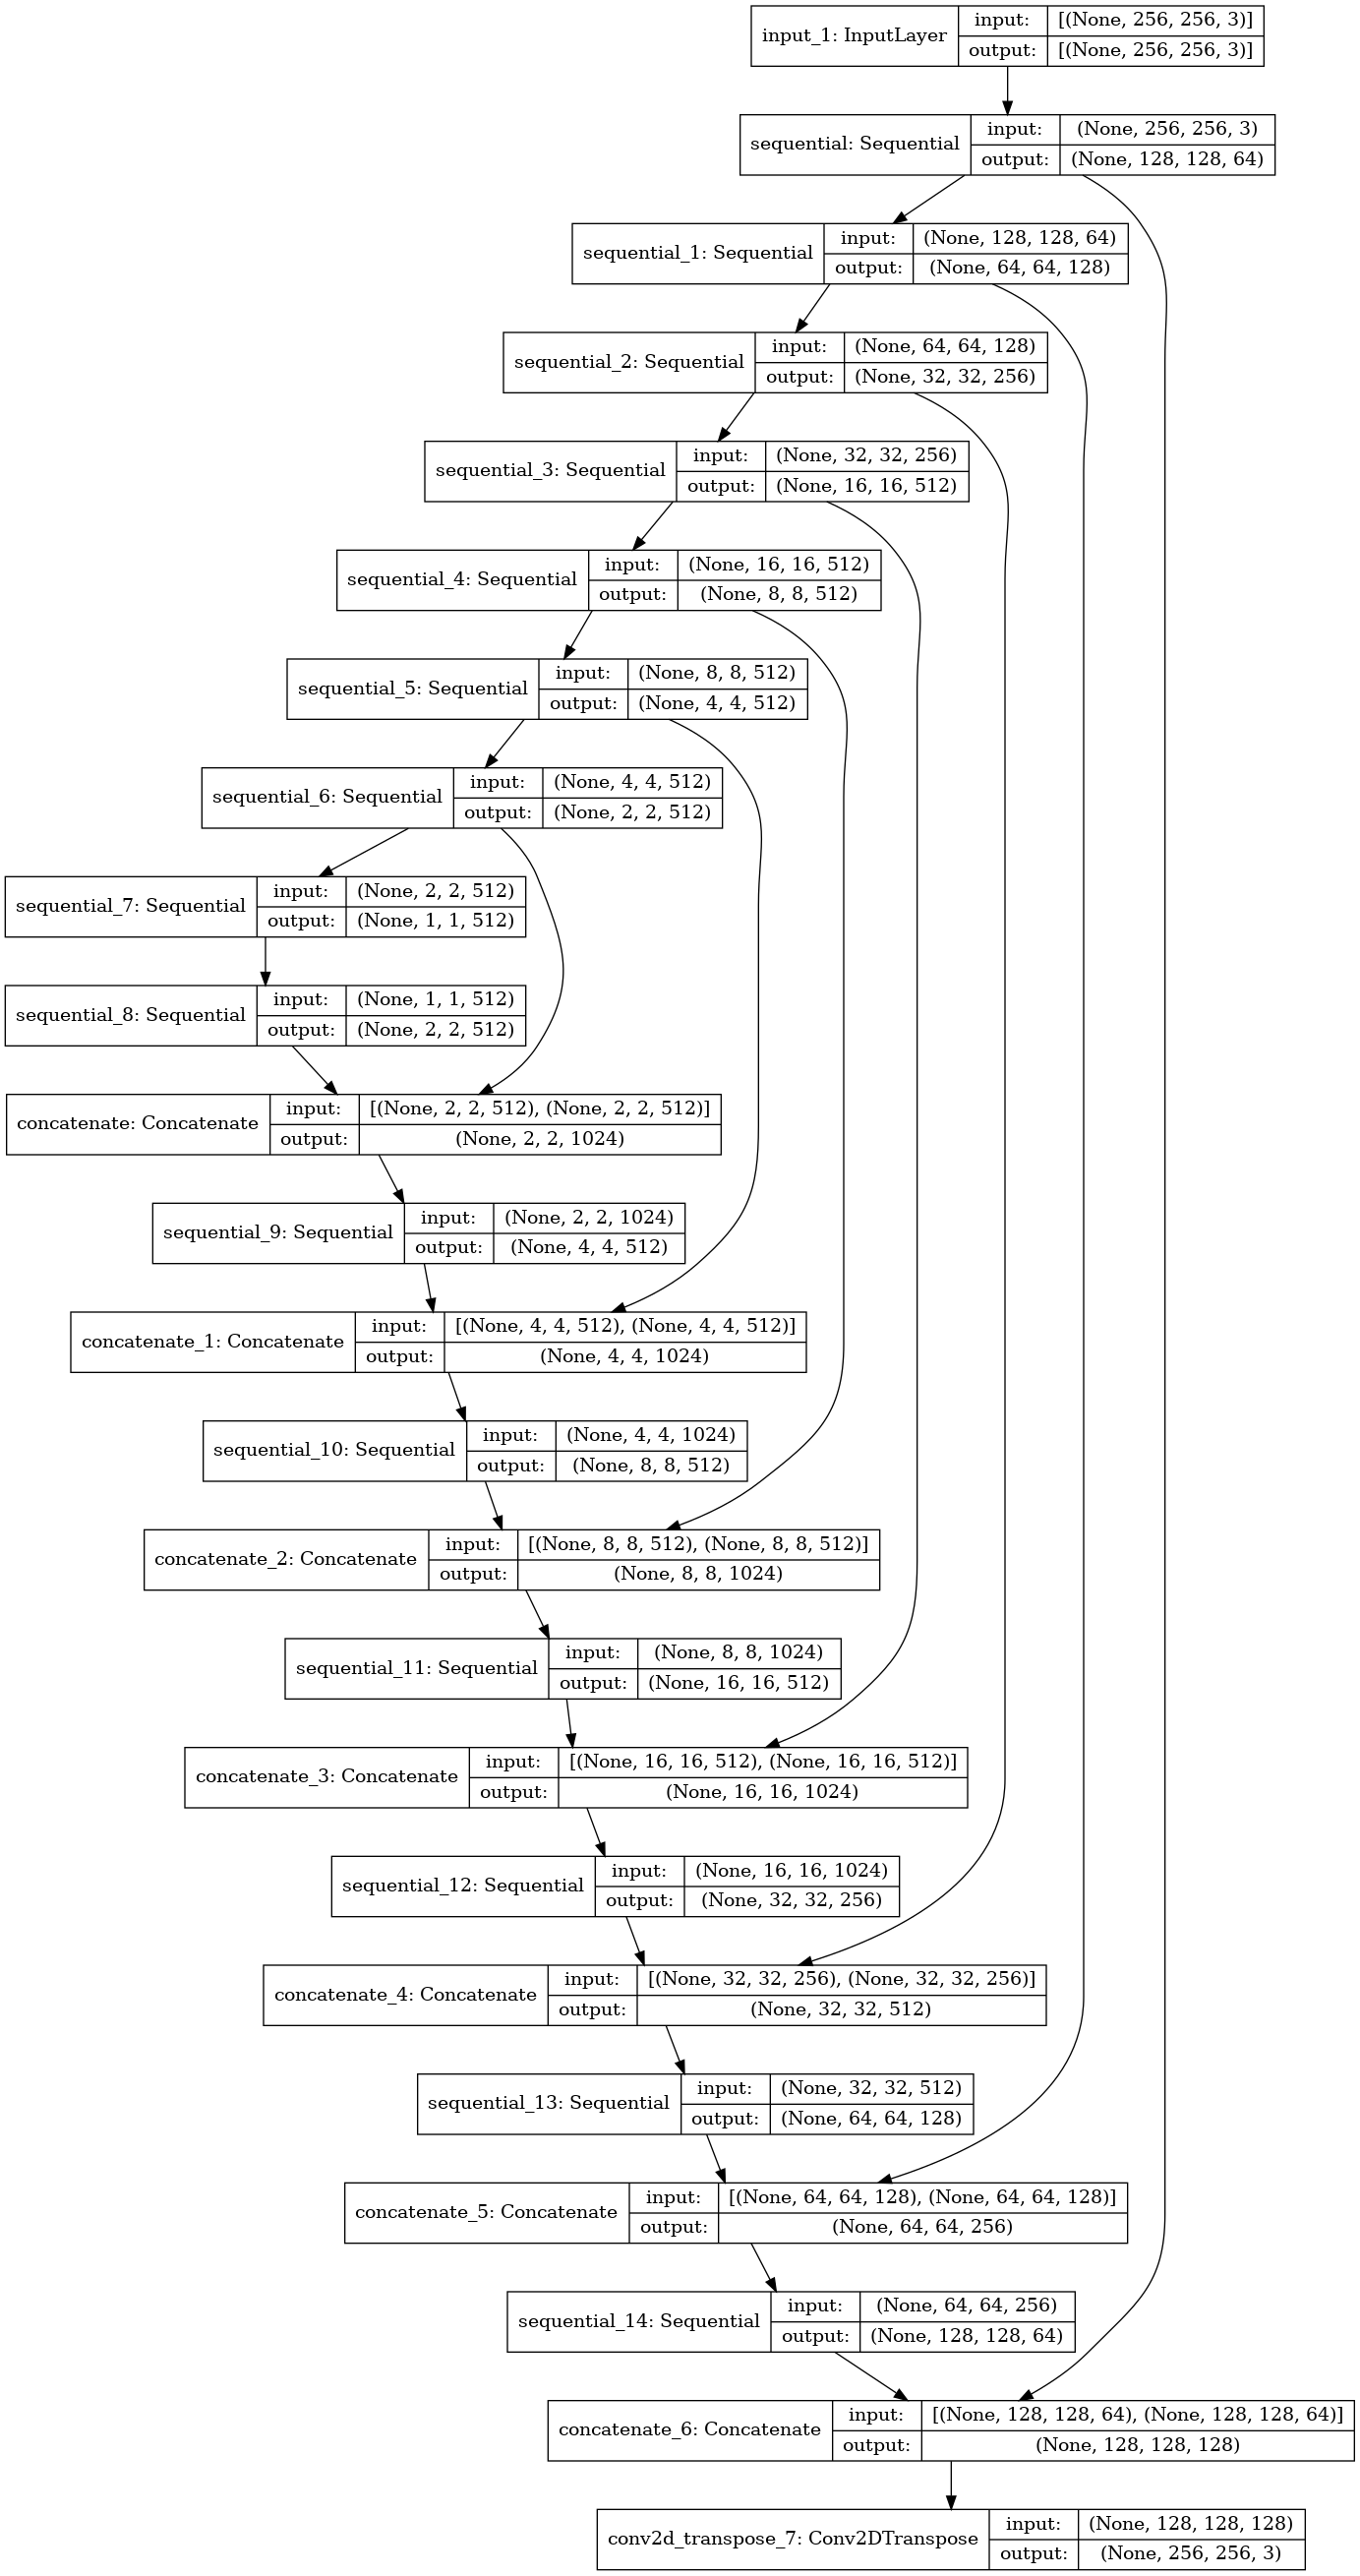

In [14]:
plot_model(monet_cycle_generator, show_shapes = True, show_layer_names = True)

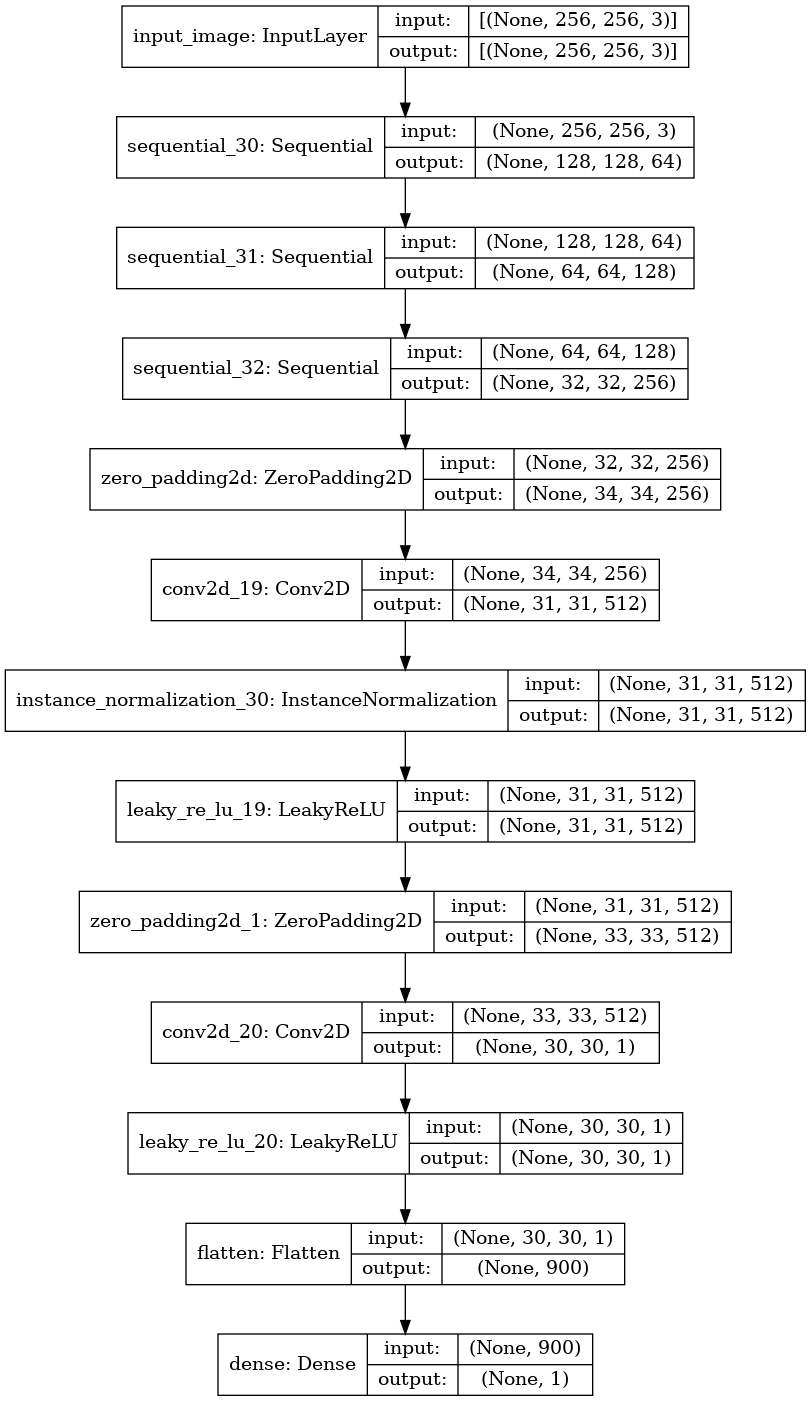

In [15]:
plot_model(monet_cycle_discriminator, show_shapes = True, show_layer_names = True)

## CycleGAN model


In [16]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
        label_real=.5
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        self.label_real = label_real
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        batch_size = tf.shape(real_photo)[0]
        labels_real = tf.zeros((batch_size, 1)) + self.label_real
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))        
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_gen_loss = self.gen_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Loss functions


In [17]:
with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2) +
                tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2))/2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
                tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)) / 2

In [18]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [19]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

## Train

In [20]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(gen_lrate, beta_1=0.9, beta_2=0.999)
    photo_generator_optimizer = tf.keras.optimizers.Adam(gen_lrate,  beta_1=0.9, beta_2=0.999)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(dis_lrate,  beta_1=0.9, beta_2=0.999)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(dis_lrate,  beta_1=0.9, beta_2=0.999)

In [21]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_cycle_generator, photo_cycle_generator, monet_cycle_discriminator, photo_cycle_discriminator, label_real=0.66
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [22]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30
)

Epoch 1/30
306/306 [==============================] - 221s 292ms/step - monet_gen_loss: 5.5668 - photo_gen_loss: 5.9262 - monet_disc_loss: 0.2830 - photo_disc_loss: 0.1883
Epoch 2/30


2022-12-11 00:20:29.826035: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 12876, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670718029.822547270","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 12876, Output num: 1","grpc_status":3}


306/306 [==============================] - 92s 291ms/step - monet_gen_loss: 4.3980 - photo_gen_loss: 3.7547 - monet_disc_loss: 0.1856 - photo_disc_loss: 0.4191
Epoch 3/30
306/306 [==============================] - 92s 292ms/step - monet_gen_loss: 4.0793 - photo_gen_loss: 3.2624 - monet_disc_loss: 0.1757 - photo_disc_loss: 0.4686
Epoch 4/30
306/306 [==============================] - 92s 291ms/step - monet_gen_loss: 4.2289 - photo_gen_loss: 3.5119 - monet_disc_loss: 0.1183 - photo_disc_loss: 0.3324
Epoch 5/30
306/306 [==============================] - 92s 292ms/step - monet_gen_loss: 3.9248 - photo_gen_loss: 3.7108 - monet_disc_loss: 0.1500 - photo_disc_loss: 0.2135
Epoch 6/30
306/306 [==============================] - 92s 291ms/step - monet_gen_loss: 3.8137 - photo_gen_loss: 3.7510 - monet_disc_loss: 0.1387 - photo_disc_loss: 0.1688
Epoch 7/30
306/306 [==============================] - 91s 290ms/step - monet_gen_loss: 3.8989 - photo_gen_loss: 4.0700 - monet_disc_loss: 0.1155 - photo_dis

## Plot Loss for Gen

In [23]:
loss_G_M = history.history['monet_gen_loss']

In [24]:
loss_G_M

[3.7734103202819824,
 4.458699703216553,
 4.348801612854004,
 3.3251090049743652,
 5.084073066711426,
 3.178420066833496,
 3.8285934925079346,
 3.8751158714294434,
 3.583073139190674,
 4.303350448608398,
 3.78656005859375,
 3.891946315765381,
 2.9755706787109375,
 3.692283868789673,
 2.497302293777466,
 3.227020502090454,
 3.6932525634765625,
 3.524446725845337,
 2.21531343460083,
 3.0090436935424805,
 3.604950189590454,
 2.960641622543335,
 3.522420644760132,
 3.3357725143432617,
 3.5971641540527344,
 2.946932554244995,
 3.4844892024993896,
 3.8268754482269287,
 3.1129844188690186,
 3.3915786743164062]

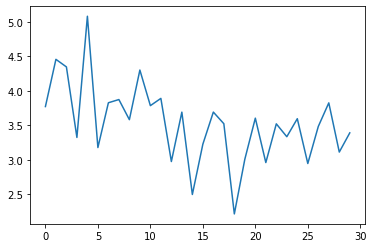

In [25]:
plt.plot(loss_G_M, label="Generator Monet")

## Visualize

2022-12-11 01:05:46.715255: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 98501, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670720746.715148255","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 98501, Output num: 0","grpc_status":3}


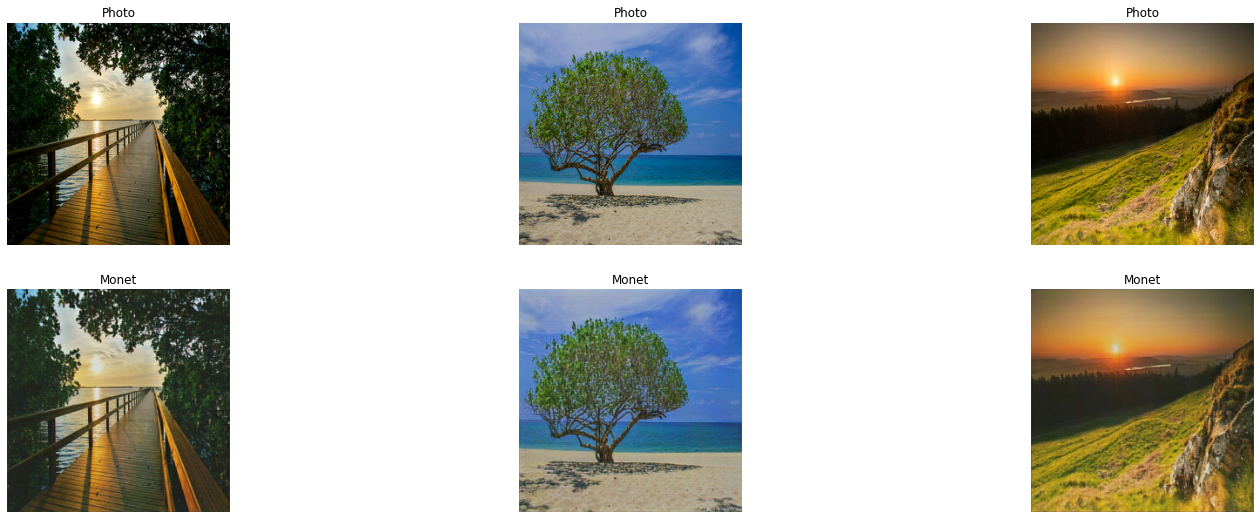

In [26]:
_, ax = plt.subplots(2, 3, figsize=(26, 9))
for i, img in enumerate(photo_ds.take(3)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Photo")
    ax[1, i].set_title("Monet")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()

## Save Model

In [27]:
#monet_cycle_discriminator.save("../models/monet_cycle_discriminator_100.h5")
#photo_cycle_discriminator.save("../models/photo_cycle_discriminator_100.h5")
#photo_cycle_generator.save("../models/photo_cycle_generator_100.h5")
#monet_cycle_generator.save("../models/monet_cycle_generator_100.h5")

In [28]:
#import shutil
#shutil.make_archive("/kaggle/working/models", 'zip', "/kaggle/models")

# Submission

In [29]:
import PIL
! mkdir ../images

In [30]:
for i, img in enumerate(photo_ds.take(9999)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")

2022-12-11 01:28:00.899768: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 372812, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1670722080.899597124","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 372812, Output num: 0","grpc_status":3}


In [31]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

'/kaggle/working/images.zip'